In [9]:
import json
import jsondiff
import numpy as np
import matplotlib.pyplot as plt
import smopy
from numpy.random import default_rng
import scipy.stats
from scipy.spatial import distance
import mplleaflet
from geopy import distance as geopy_distance

In [18]:
def extract_json_positions(data):
    '''
    Extract position tuples (latitude, longitude) from critical maps json.
    
    Parameters:
    data : dictonary
        json dictonary from critical maps website with n
        (longitude, latitude) tuples
    Returns:
    positions : numpy 2xn array
    '''
    locations = data['locations']
    positions = np.empty((0,2));
    for ident in locations:
        loc = locations[ident]
        positions=np.append(positions,[[loc['latitude']*1e-6,loc['longitude']*1e-6]],axis=0)
    return positions

def open_cm_log(path):
    ''' Open logged json in path, return json'''
    with open(path,'r') as f:
        data = json.load(f);
    return data
def distance_per_pixel(latitude,zoomlevel):
    ''' Calculate horizontal distance of each pixel for a given zoomlevel at a specific latitude (in degrees) '''
    C = 40075016.686; # Equotrial circumference of the earth
    return C*np.cos(latitude*np.pi/180)/2**(zoomlevel+8)


def get_points_in_circle(positions,center,radius_km):
    ''' Return positions (long, latidude) which are in a circle at center (longitude, latidude) with radius given in km '''
    pclose = []
    for p in positions:
        if geopy_distance.geodesic(p,center).km <= radius_km:
            pclose.append(p)
    return np.array(pclose)
    
name = 'cm_logs/20220624_202509.txt' # works okayis
#name = 'cm_logs/20220624_210255.txt' 
data = open_cm_log(name)
positions = extract_json_positions(data)
coord_HH = [53.5488, 9.9872];
positions_city = get_points_in_circle(positions, coord_HH, 20)
median = np.mean(positions_city,axis=0)
positions_fine = get_points_in_circle(positions_city, median, 3)
plt.plot(median[1],median[0],'xr',ms=20)
plt.plot(positions_fine[:,1],positions_fine[:,0],'.') #plot longitude, latitude
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [3]:
#https://www.ipol.im/pub/art/2017/176/article.pdf
# An Unsupervised Algorithm for Detecting Good Continuation in Dot Patterns, Lezama et al.
b = 5 # number of nearest neighbours used for exploration, default in paper: 5
lam = 4 # porportion of the local window radius w.r.t. the triplet size, default in paper: 4
delta = 10*256/256 # minimum discrete precision of the domain
pos = [np.array([x*px_scale,y*px_scale]) for x,y in zip(positions_px_x,positions_px_y)]
pos = [p for p in pos if (min(xlim_m) <= p[0] <= max(xlim_m)) and
                                  (min(ylim_m) <= p[1] <= max(ylim_m))]
pos_np = np.array(pos)
# Calculate distance maps
# https://stackoverflow.com/questions/48312205/find-the-k-nearest-neighbours-of-a-point-in-3d-space-with-python-numpy
D = distance.squareform(distance.pdist(pos))
N = len(pos)
closest = np.argsort(D, axis=1) #each line represents closest point indices

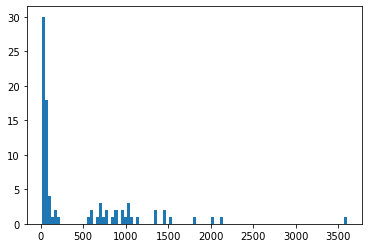

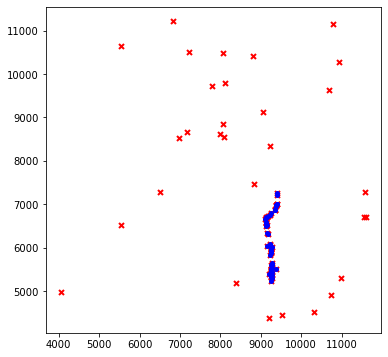

In [4]:
crit = np.mean(np.sort(D,axis=1)[:,1:5],axis=1)
counts,edges = np.histogram(crit,bins=101)
plt.stairs(counts,edges,fill=True)
plt.show()
plt.figure(figsize=(6,6))
selec = crit<4*np.median(crit)
plt.plot(pos_np[:,0],pos_np[:,1], 'xr', ms=5, mew=2);
plt.plot(pos_np[selec,0],pos_np[selec,1], 'ob', ms=3, mew=2);
p1 = pos_np[selec,:]
D_selec = distance.squareform(distance.pdist(p1))
N_selec = len(p1)
closest_selec = np.argsort(D_selec, axis=1) #each line represents closest point indices

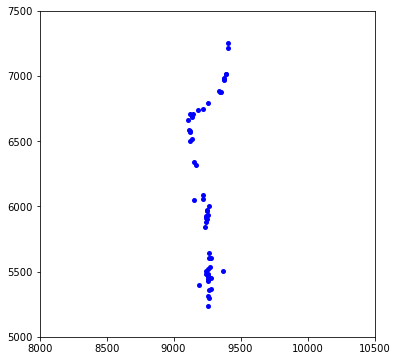

In [5]:
plt.figure(figsize=(6,6))
plt.plot(p1[:,0],p1[:,1], 'ob', ms=3, mew=2);
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

Notes:
https://stackoverflow.com/questions/61143998/numpy-best-fit-line-with-outliers
file:///C:/Users/Hauke/Downloads/AlgorithmsNotesForProfessionals.pdf
https://favtutor.com/blogs/floyd-warshall-algorithm

http://www.ipol.im/pub/art/2019/234/article.pdf
https://www.ipol.im/pub/art/2017/176/article.pdf

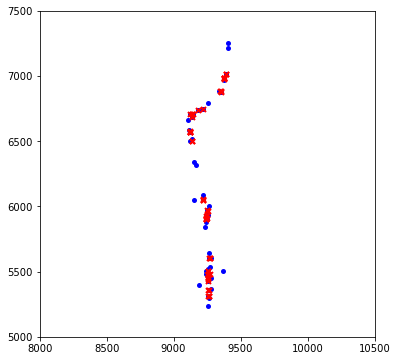

In [6]:
# Do some averaging to get rid of small outliers (people blocking traffic)
n=3
p1_avg = np.copy(p1)
for ii in range(N_selec):
    p1_avg[ii,:] = np.median(p1[closest_selec[ii,1:n+1],:],axis=0)
plt.figure(figsize=(6,6))
plt.plot(p1[:,0],p1[:,1], 'ob', ms=3, mew=2);
plt.plot(p1_avg[:,0],p1_avg[:,1], 'xr', ms=5, mew=2);
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

30 [9260.27896358 5314.53328295]


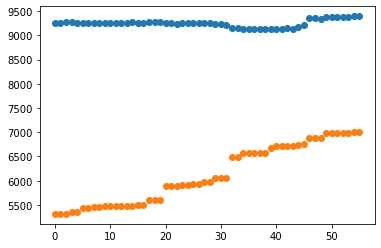

In [7]:
# 1. Sorting points
def sort_points(points):
    sorted_points = []
    sorted_mark = np.array(np.zeros(np.size(points,0)),dtype=bool)
    sorted_points = np.empty(np.shape(points))
    sorted_points[:] = np.nan
    jj = 0
    # Select first point
    first_point = np.argmin(points[:,1])
    print(first_point,points[first_point,:])
    sorted_points[jj,:] = points[first_point,:]
    #Mark first point as sorted
    sorted_mark[first_point] = True
    while not np.all(sorted_mark):
        #print(jj)
        cp = sorted_points[jj,:]
        unsorted_points = points.copy()
        unsorted_points[sorted_mark,:] = [np.nan,np.nan]
        d = np.sqrt((unsorted_points[:,0]-cp[0])**2 + (unsorted_points[:,1]-cp[1])**2)
        ii = np.nanargmin(d)
        jj = jj + 1
        sorted_points[jj,:] = unsorted_points[ii]
        sorted_mark[ii] = True
    return sorted_points
p2 = sort_points(p1_avg)
plt.plot(p2[:,0],'o')
plt.plot(p2[:,1],'o')

#Roll array such that first element has minimum first coordinate
#roll_ii = np.argminb(p2[:,0])
#print(roll_ii)
#p2 = np.roll(p2,roll_ii,axis=0)

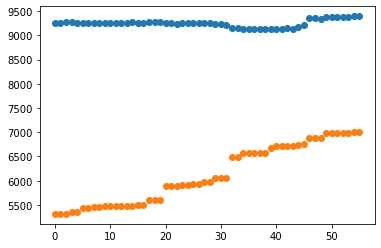

In [8]:
def find_starting_point(points):
    mindist = np.inf
    minidx = 0
    for i in range(len(points)):
        ordered = np.roll(points,i,axis=0)    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        if cost < mindist:
            mindist = cost
            minidx = i
    return np.roll(points,minidx,axis=0)
p3 = find_starting_point(p2)
plt.plot(p3[:,0],'o')
plt.plot(p3[:,1],'o')

In [9]:
from scipy import interpolate

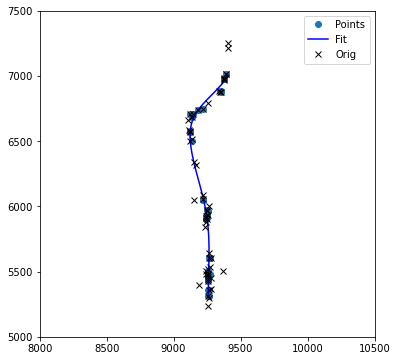

Length: 1800.761170772768


In [44]:
# 2. Fit sorted points
#https://scipy.github.io/devdocs/tutorial/interpolate.html
unique_idx = np.unique(p3,axis=0,return_index=True)[1] # disregard sorted unique output, just indices
p3uniq = np.array([p3[index] for index in sorted(unique_idx)])
x,y = p3uniq[:,0],p3uniq[:,1]
tck, u = interpolate.splprep([x, y], s=10000)
umore = 0
unew = np.arange(0-umore, 1.01+umore,0.01)
out = interpolate.splev(unew, tck)
plt.figure(figsize=(6,6))
plt.plot(x, y, 'o', out[0], out[1],'b')
plt.plot(p1[:,0],p1[:,1],'xk')
plt.legend(['Points','Fit','Orig'])
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);
plt.show()
# Calculate length
diffs = np.sqrt((out[0][:-1] - out[0][1:])**2 + (out[1][:-1] - out[1][1:])**2)
length = sum(diffs)
print('Length:', length)

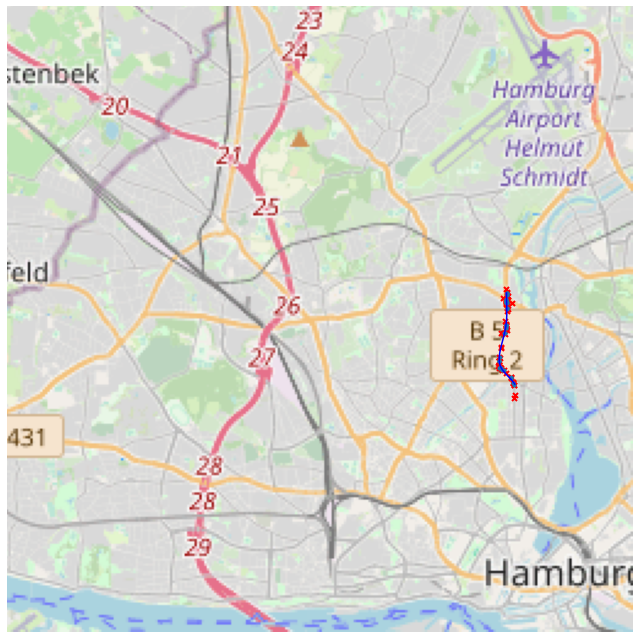

In [45]:
#px_scale_z14 = distance_per_pixel(latitude, mapHH_z14.z)
ax = mapHH.show_mpl(figsize=(12, 9))
ax.plot(p1[:,0]/px_scale,p1[:,1]/px_scale, 'xr', ms=5, mew=2);
ax.plot(x/px_scale, y/px_scale, '.', out[0]/px_scale, out[1]/px_scale,'b')